# Change Detection With `vaxflux`

This notebook walks through an example of using `vaxflux` on synthetic data for detection a change in vaccine uptake with a new season.

In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.integrate import cumulative_trapezoid
from scipy.special import logit
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns

# `vaxflux` imports
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import create_logistic_sample_dataset
from vaxflux.model import build_model, change_detection

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parameters = pd.DataFrame.from_records(
    [
        {
            "season": "2022/23",
            "strata": "Male",
            "region": "National",
            "r": 0.4,
            "m": logit(0.6),
            "s": 14.0,
        },
        {
            "season": "2023/24",
            "strata": "Male",
            "region": "National",
            "r": 0.4,
            "m": logit(0.55),
            "s": 14.0,
        },
        {
            "season": "2024/25",
            "strata": "Male",
            "region": "National",
            "r": 0.35,
            "m": logit(0.65),
            "s": 18.0,
        },
        {
            "season": "2022/23",
            "strata": "Female",
            "region": "National",
            "r": 0.425,
            "m": logit(0.6),
            "s": 14.0,
        },
        {
            "season": "2023/24",
            "strata": "Female",
            "region": "National",
            "r": 0.425,
            "m": logit(0.55),
            "s": 14.0,
        },
        {
            "season": "2024/25",
            "strata": "Female",
            "region": "National",
            "r": 0.425,
            "m": logit(0.65),
            "s": 14.0,
        },
    ]
)
parameters

season  strata    region      r         m     s
0  2022/23    Male  National  0.400  0.405465  14.0
1  2023/24    Male  National  0.400  0.200671  14.0
2  2024/25    Male  National  0.350  0.619039  18.0
3  2022/23  Female  National  0.425  0.405465  14.0
4  2023/24  Female  National  0.425  0.200671  14.0
5  2024/25  Female  National  0.425  0.619039  14.0

In [3]:
time = np.arange(1, 35)
epsilon = 0.001
incidence = create_logistic_sample_dataset(parameters, time, epsilon)
incidence.head()

season strata    region  time     value
0  2022/23   Male  National   1.0  0.003563
1  2022/23   Male  National   2.0  0.002182
2  2022/23   Male  National   3.0  0.005023
3  2022/23   Male  National   4.0  0.003265
4  2022/23   Male  National   5.0  0.006058

This dataset has a couple of interesting features:

1. Broadly, this dataset is one region (think national or one state) with two stratifications, Female and Male, over the course of 35 weeks,
2. Generally speaking the uptake between Females and Males is similar for the 2022/23 and 2023/24 seasons but Females have a slightly quicker uptake, but
3. For the 2024/25 season there is a significant delay in uptake (both in time and rate) for Males which is a problem.

<Axes: xlabel='time', ylabel='value'>

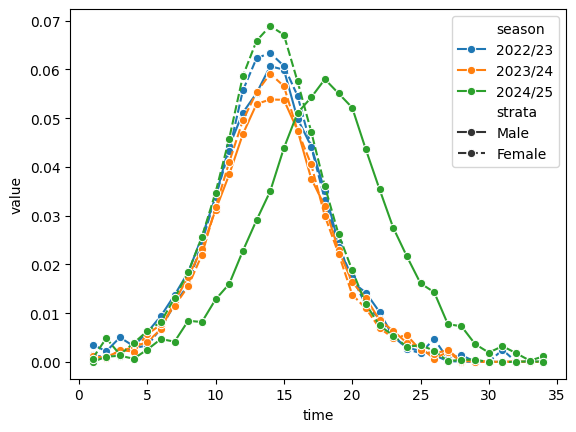

In [4]:
sns.lineplot(incidence, x="time", y="value", hue="season", style="strata", marker="o")

/var/folders/2z/h3pc0p7s3ng1tvxrgsw5kr680000gp/T/ipykernel_53418/3317311011.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_cumulative_integral)


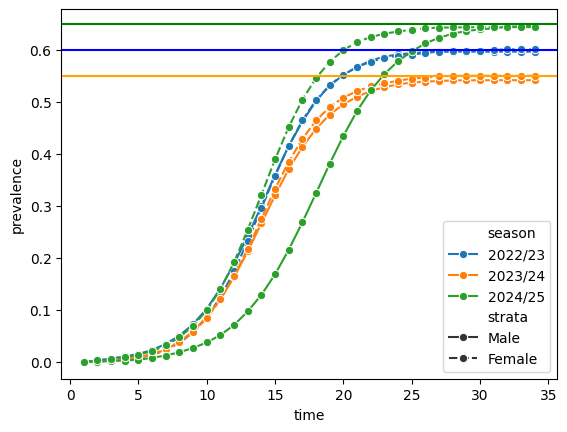

In [5]:
def compute_cumulative_integral(group):
    return pd.Series(
        data=cumulative_trapezoid(
            group["value"].values, x=group["time"].values, initial=0.0
        ),
        index=group.index,
    )


incidence["prevalence"] = incidence.groupby(
    ["season", "strata", "region"], group_keys=False
).apply(compute_cumulative_integral)
g = sns.lineplot(
    incidence, x="time", y="prevalence", hue="season", style="strata", marker="o"
)
g.axhline(y=0.6, color="blue")
g.axhline(y=0.55, color="orange")
g.axhline(y=0.65, color="green")

Now that we've visualized this dataset, let's walk through modeling these uptakes with `vaxflux`. We're going to build/sample three models:

1. A "before" model that excludes the 2024/25 season,
2. An "after" model that includes the full 2024/25 season, and
3. A "midway" model that includes only six weeks from the 2024/25 season.

In [6]:
logistic_curve = LogisticIncidenceCurve()

In [7]:
model_before = build_model(
    incidence[incidence["season"] != "2024/25"],
    "incidence",
    "rate",
    logistic_curve,
    pm.Normal,
    (pm.HalfNormal, {"sigma": 0.002}),
    {
        "m": (pm.Normal, {"mu": 1.0, "sigma": 1.0}),
        "r": (pm.Normal, {"mu": 0.5, "sigma": 0.05}),
        "s": (pm.Normal, {"mu": 10.0, "sigma": 2.0}),
        "mStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
        "rStrata": (pm.Laplace, {"mu": 0.0, "b": 0.01}),
        "sStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
    },
    season_stratified_parameters=("m", "r", "s"),
)
model_before

   mMacro ~ Normal(1, 1)
  mStrata ~ Laplace(0, 0.2)
   rMacro ~ Normal(0.5, 0.05)
  rStrata ~ Laplace(0, 0.01)
   sMacro ~ Normal(10, 2)
  sStrata ~ Laplace(0, 0.2)
  epsilon ~ HalfNormal(0, 0.002)
        m ~ Deterministic(f(mStrata, mMacro))
        r ~ Deterministic(f(rStrata, rMacro))
        s ~ Deterministic(f(sStrata, sMacro))
   yModel ~ Deterministic(f(rStrata, rMacro, mStrata, sStrata, mMacro, sMacro))
yObserved ~ Normal(yModel, epsilon)

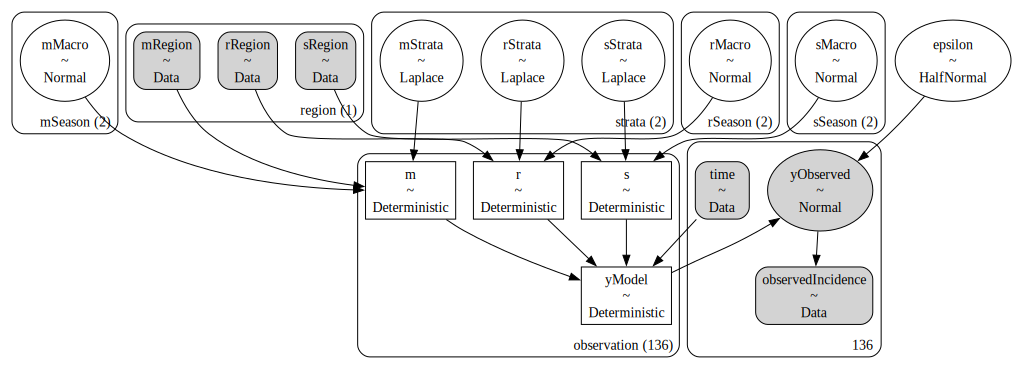

In [8]:
pm.model_to_graphviz(model_before)

In [9]:
chains = 4
samples = 1000 * chains
with model_before:
    trace_before = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=chains, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 38 seconds.


In [10]:
az.summary(trace_before)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
epsilon      0.001  0.000   0.001    0.001        0.0      0.0   10102.0   
m[0]         0.415  0.017   0.383    0.448        0.0      0.0   17384.0   
m[1]         0.415  0.017   0.383    0.448        0.0      0.0   17384.0   
m[2]         0.415  0.017   0.383    0.448        0.0      0.0   17384.0   
m[3]         0.415  0.017   0.383    0.448        0.0      0.0   17384.0   
...            ...    ...     ...      ...        ...      ...       ...   
yModel[131]  0.000  0.000   0.000    0.000        0.0      0.0   17710.0   
yModel[132]  0.000  0.000   0.000    0.000        0.0      0.0   17729.0   
yModel[133]  0.000  0.000   0.000    0.000        0.0      0.0   17748.0   
yModel[134]  0.000  0.000   0.000    0.000        0.0      0.0   17766.0   
yModel[135]  0.000  0.000   0.000    0.000        0.0      0.0   17782.0   

             ess_tail  r_hat  
epsilon        9158.0    1.0  
m[0]          14727.0    1.0  
m[1]          14727.0    1.0  
m[2]          14727.0    1.0  
m[3]          14727.0    1.0  
...               ...    ...  
yModel[131]   12554.0    1.0  
yModel[132]   12658.0    1.0  
yModel[133]   12507.0    1.0  
yModel[134]   12458.0    1.0  
yModel[135]   12432.0    1.0  

[557 rows x 9 columns]

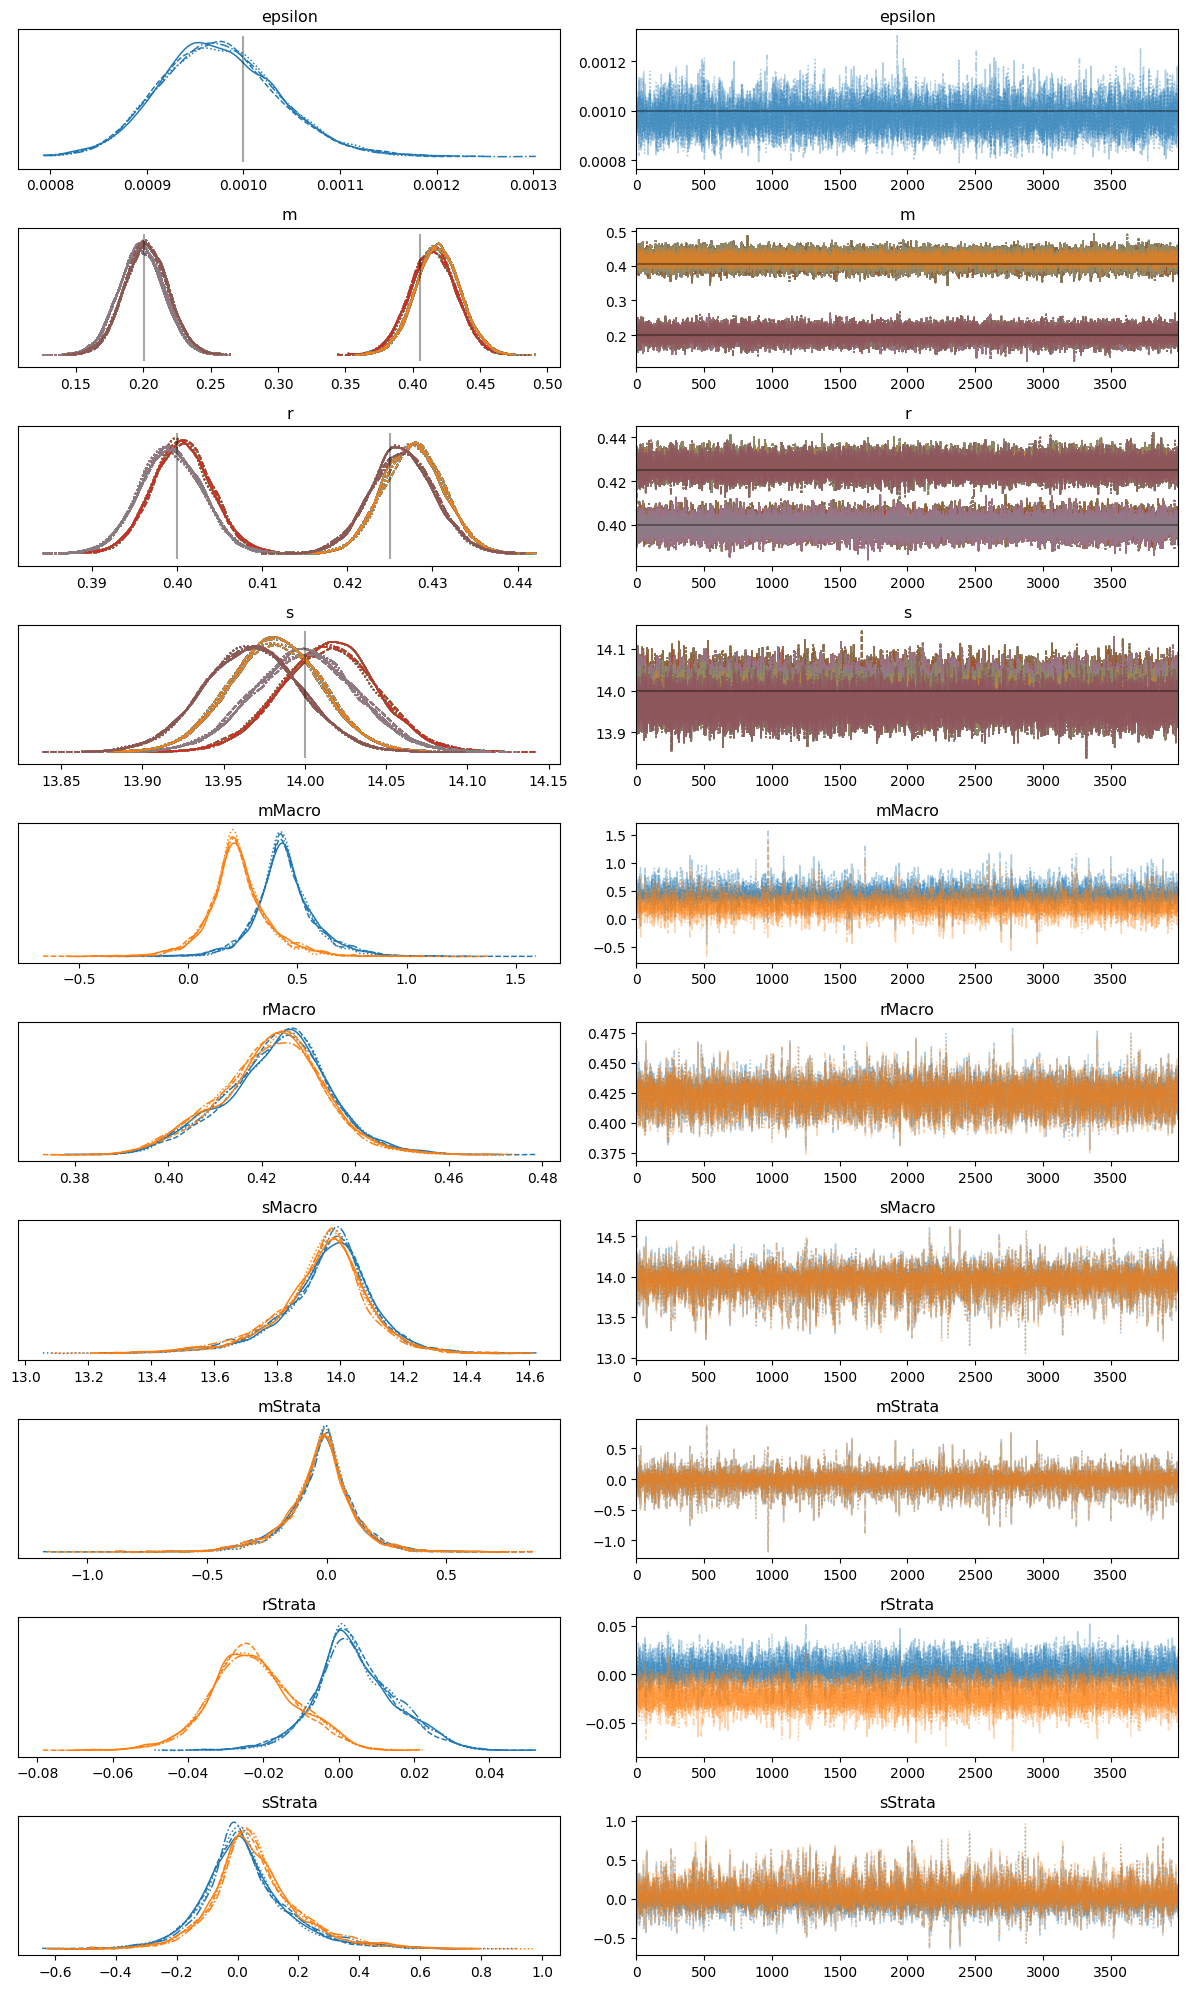

In [11]:
axes = az.plot_trace(
    trace_before,
    var_names=[
        "epsilon",
        "m",
        "r",
        "s",
        "mMacro",
        "rMacro",
        "sMacro",
        "mStrata",
        "rStrata",
        "sStrata",
    ],
    kind="trace",
    lines=[
        ("epsilon", {}, 0.001),
        ("m", {}, logit([0.6, 0.55])),
        ("r", {}, [0.4, 0.425]),
        ("s", {}, 14.0),
    ],
)
plt.tight_layout()

In [12]:
model_after = build_model(
    incidence,
    "incidence",
    "rate",
    logistic_curve,
    pm.Normal,
    (pm.HalfNormal, {"sigma": 0.002}),
    {
        "m": (pm.Normal, {"mu": 1.0, "sigma": 1.0}),
        "r": (pm.Normal, {"mu": 0.5, "sigma": 0.05}),
        "s": (pm.Normal, {"mu": 10.0, "sigma": 2.0}),
        "mStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
        "rStrata": (pm.Laplace, {"mu": 0.0, "b": 0.01}),
        "sStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
    },
    season_stratified_parameters=("m", "r", "s"),
)
model_after

   mMacro ~ Normal(1, 1)
  mStrata ~ Laplace(0, 0.2)
   rMacro ~ Normal(0.5, 0.05)
  rStrata ~ Laplace(0, 0.01)
   sMacro ~ Normal(10, 2)
  sStrata ~ Laplace(0, 0.2)
  epsilon ~ HalfNormal(0, 0.002)
        m ~ Deterministic(f(mStrata, mMacro))
        r ~ Deterministic(f(rStrata, rMacro))
        s ~ Deterministic(f(sStrata, sMacro))
   yModel ~ Deterministic(f(rStrata, rMacro, mStrata, sStrata, mMacro, sMacro))
yObserved ~ Normal(yModel, epsilon)

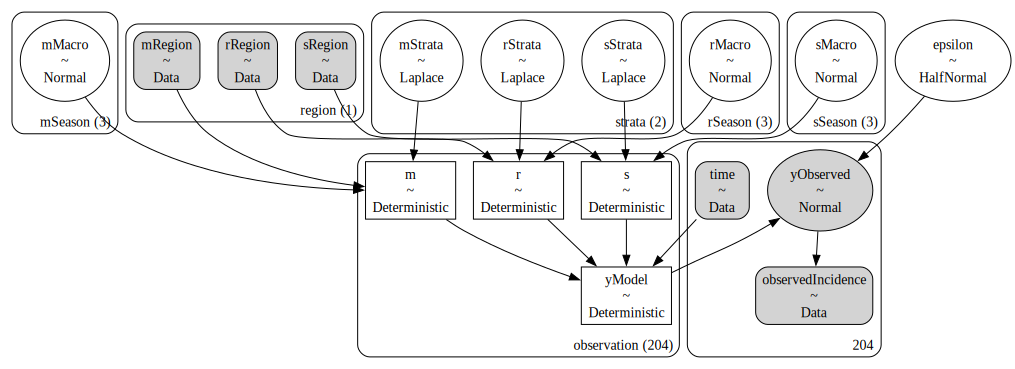

In [13]:
pm.model_to_graphviz(model_after)

In [14]:
with model_after:
    trace_after = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=chains, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 17 seconds.


In [15]:
az.summary(trace_after)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
epsilon      0.005  0.000   0.004    0.005      0.000      0.0   15697.0   
m[0]         0.402  0.076   0.259    0.545      0.001      0.0   18106.0   
m[1]         0.402  0.076   0.259    0.545      0.001      0.0   18106.0   
m[2]         0.402  0.076   0.259    0.545      0.001      0.0   18106.0   
m[3]         0.402  0.076   0.259    0.545      0.001      0.0   18106.0   
...            ...    ...     ...      ...        ...      ...       ...   
yModel[199]  0.001  0.000   0.000    0.001      0.000      0.0   15824.0   
yModel[200]  0.000  0.000   0.000    0.001      0.000      0.0   15836.0   
yModel[201]  0.000  0.000   0.000    0.000      0.000      0.0   15846.0   
yModel[202]  0.000  0.000   0.000    0.000      0.000      0.0   15857.0   
yModel[203]  0.000  0.000   0.000    0.000      0.000      0.0   15875.0   

             ess_tail  r_hat  
epsilon       11512.0    1.0  
m[0]          14302.0    1.0  
m[1]          14302.0    1.0  
m[2]          14302.0    1.0  
m[3]          14302.0    1.0  
...               ...    ...  
yModel[199]   11034.0    1.0  
yModel[200]   11031.0    1.0  
yModel[201]   10931.0    1.0  
yModel[202]   10935.0    1.0  
yModel[203]   10833.0    1.0  

[832 rows x 9 columns]

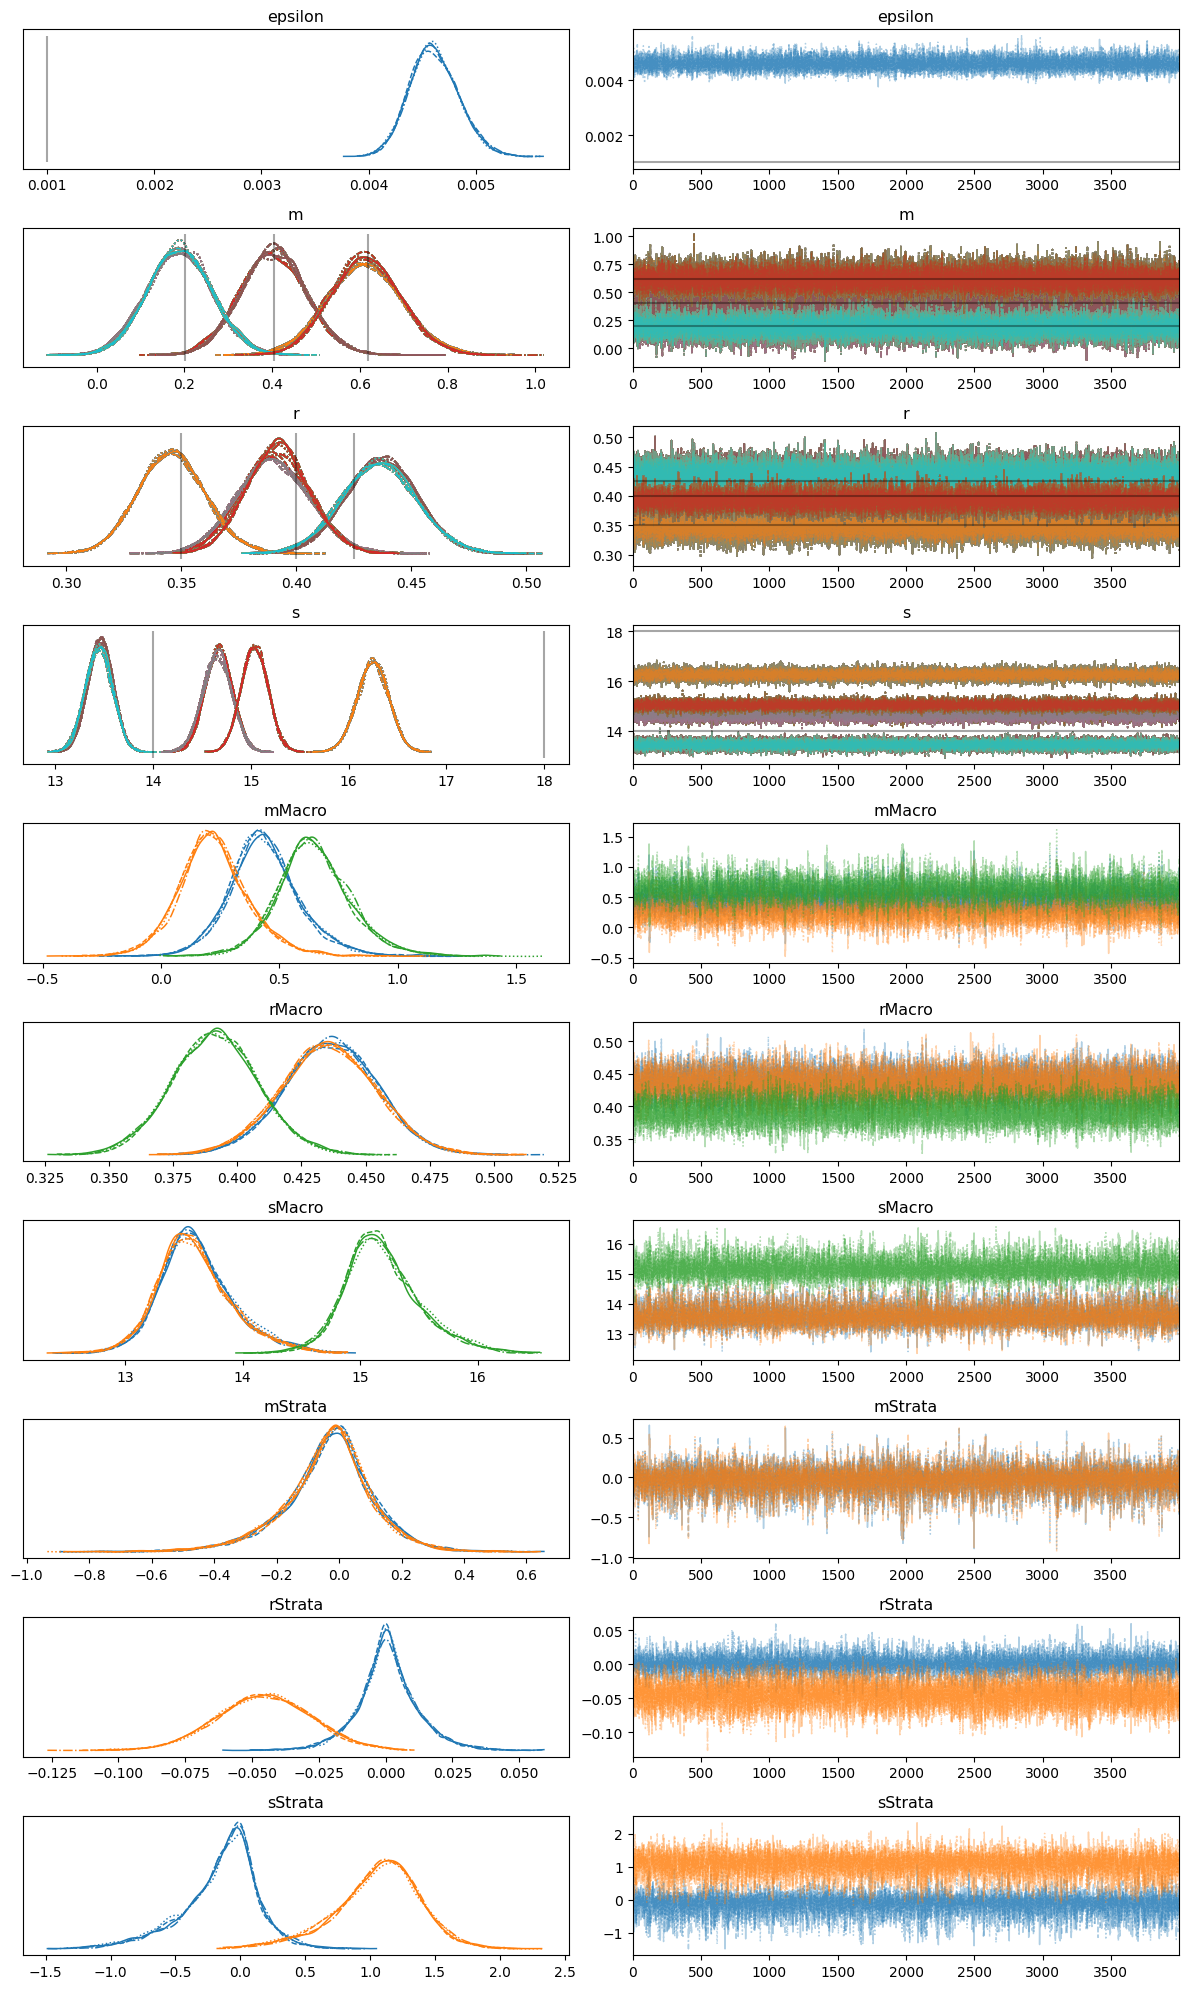

In [16]:
axes = az.plot_trace(
    trace_after,
    var_names=[
        "epsilon",
        "m",
        "r",
        "s",
        "mMacro",
        "rMacro",
        "sMacro",
        "mStrata",
        "rStrata",
        "sStrata",
    ],
    kind="trace",
    lines=[
        ("epsilon", {}, 0.001),
        ("m", {}, logit([0.6, 0.55, 0.65])),
        ("r", {}, [0.4, 0.425, 0.35]),
        ("s", {}, [14.0, 18.0]),
    ],
)
plt.tight_layout()

In [17]:
results = change_detection(
    trace_before,
    trace_after,
    (
        {
            "T-Test": lambda x, y: ttest_ind(x, y, equal_var=False),
            "Mean": lambda x, y: np.mean(x) - np.mean(y),
        },
        {"U-Test": mannwhitneyu, "Median": lambda x, y: np.median(x) - np.median(y)},
    ),
    logistic_curve.parameters,
    "strata",
)
with np.errstate(divide="ignore"):
    results["p_value"] = np.log10(results["p_value"])
results

kind param    name    test  metric  test_statistic     p_value  \
0   strata     m  Female  T-Test    Mean   -5.872533e+00   -8.363081   
1   strata     m  Female  U-Test  Median    1.230333e+08   -8.734568   
2   strata     m    Male  T-Test    Mean   -5.427187e+00   -7.239086   
3   strata     m    Male  U-Test  Median    1.237486e+08   -6.573565   
4   strata     r  Female  T-Test    Mean   -2.942730e+01 -187.095960   
5   strata     r  Female  U-Test  Median    1.034353e+08 -193.507424   
6   strata     r    Male  T-Test    Mean   -1.372927e+02        -inf   
7   strata     r    Male  U-Test  Median    3.539195e+07        -inf   
8   strata     s  Female  T-Test    Mean   -6.766154e+01        -inf   
9   strata     s  Female  U-Test  Median    7.785601e+07        -inf   
10  strata     s    Male  T-Test    Mean    3.496503e+02        -inf   
11  strata     s    Male  U-Test  Median    2.538867e+08        -inf   

    metric_value  
0      -0.009407  
1      -0.009155  
2      -0.008675  
3      -0.006163  
4      -0.003694  
5      -0.002951  
6      -0.022734  
7      -0.022003  
8      -0.177582  
9      -0.110649  
10      1.001193  
11      1.050735

# Early Season Detection

In [18]:
incidence_midway = incidence[
    (incidence["season"] != "2024/25")
    | ((incidence["season"] == "2024/25") & (incidence["time"] <= 6))
].copy()

<Axes: xlabel='time', ylabel='value'>

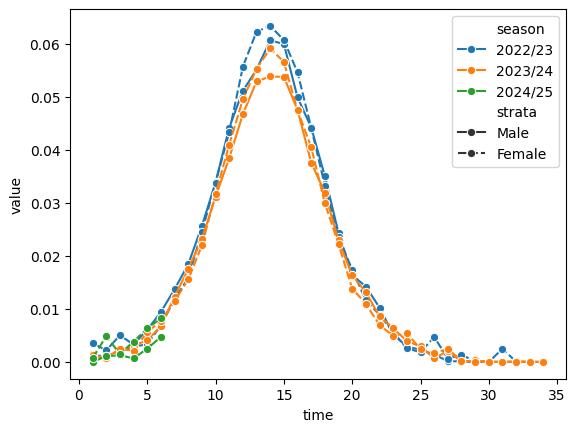

In [19]:
sns.lineplot(
    incidence_midway, x="time", y="value", hue="season", style="strata", marker="o"
)

/var/folders/2z/h3pc0p7s3ng1tvxrgsw5kr680000gp/T/ipykernel_53418/852964232.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_cumulative_integral)


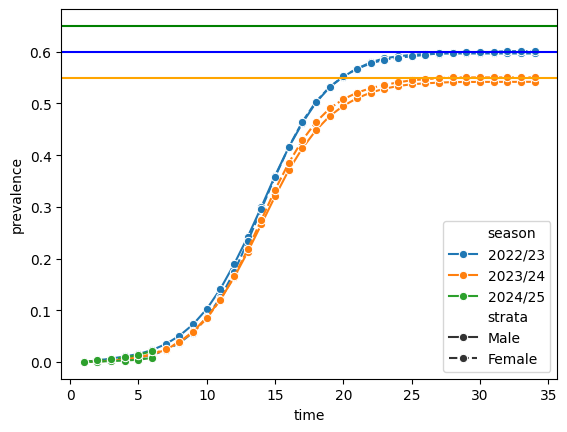

In [20]:
incidence_midway["prevalence"] = incidence_midway.groupby(
    ["season", "strata", "region"], group_keys=False
).apply(compute_cumulative_integral)
g = sns.lineplot(
    incidence_midway, x="time", y="prevalence", hue="season", style="strata", marker="o"
)
g.axhline(y=0.6, color="blue")
g.axhline(y=0.55, color="orange")
g.axhline(y=0.65, color="green")

In [21]:
model_midway = build_model(
    incidence_midway,
    "incidence",
    "rate",
    logistic_curve,
    pm.Normal,
    (pm.HalfNormal, {"sigma": 0.002}),
    {
        "m": (pm.Normal, {"mu": 1.0, "sigma": 1.0}),
        "r": (pm.Normal, {"mu": 0.5, "sigma": 0.05}),
        "s": (pm.Normal, {"mu": 10.0, "sigma": 2.0}),
        "mStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
        "rStrata": (pm.Laplace, {"mu": 0.0, "b": 0.01}),
        "sStrata": (pm.Laplace, {"mu": 0.0, "b": 0.2}),
    },
    season_stratified_parameters=("m", "r", "s"),
)
model_midway

   mMacro ~ Normal(1, 1)
  mStrata ~ Laplace(0, 0.2)
   rMacro ~ Normal(0.5, 0.05)
  rStrata ~ Laplace(0, 0.01)
   sMacro ~ Normal(10, 2)
  sStrata ~ Laplace(0, 0.2)
  epsilon ~ HalfNormal(0, 0.002)
        m ~ Deterministic(f(mStrata, mMacro))
        r ~ Deterministic(f(rStrata, rMacro))
        s ~ Deterministic(f(sStrata, sMacro))
   yModel ~ Deterministic(f(rStrata, rMacro, mStrata, sStrata, mMacro, sMacro))
yObserved ~ Normal(yModel, epsilon)

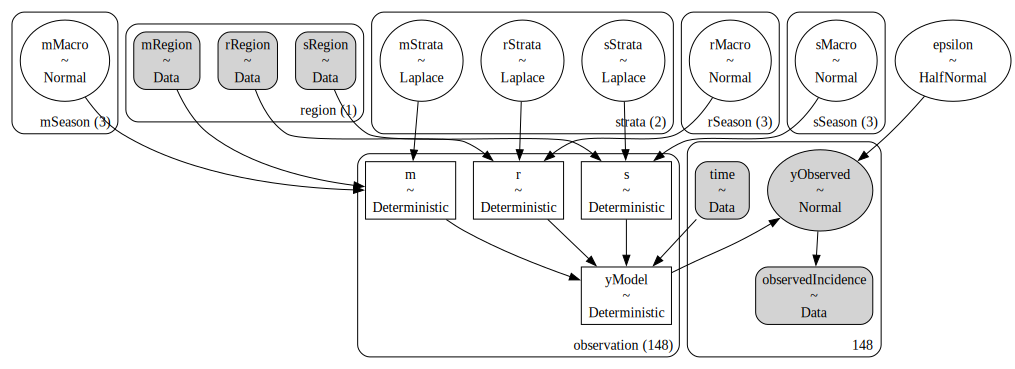

In [22]:
pm.model_to_graphviz(model_midway)

In [23]:
with model_midway:
    trace_midway = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=chains, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 43 seconds.


In [24]:
az.summary(trace_midway)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
epsilon      0.001  0.000   0.001    0.001        0.0      0.0   17337.0   
m[0]         0.408  0.019   0.371    0.441        0.0      0.0   16250.0   
m[1]         0.408  0.019   0.371    0.441        0.0      0.0   16250.0   
m[2]         0.408  0.019   0.371    0.441        0.0      0.0   16250.0   
m[3]         0.408  0.019   0.371    0.441        0.0      0.0   16250.0   
...            ...    ...     ...      ...        ...      ...       ...   
yModel[143]  0.001  0.000   0.001    0.001        0.0      0.0   14652.0   
yModel[144]  0.002  0.000   0.001    0.002        0.0      0.0   14219.0   
yModel[145]  0.003  0.000   0.002    0.003        0.0      0.0   13961.0   
yModel[146]  0.004  0.000   0.003    0.005        0.0      0.0   14508.0   
yModel[147]  0.006  0.001   0.005    0.008        0.0      0.0   15715.0   

             ess_tail  r_hat  
epsilon       11468.0    1.0  
m[0]          13914.0    1.0  
m[1]          13914.0    1.0  
m[2]          13914.0    1.0  
m[3]          13914.0    1.0  
...               ...    ...  
yModel[143]   12736.0    1.0  
yModel[144]   12852.0    1.0  
yModel[145]   13216.0    1.0  
yModel[146]   11872.0    1.0  
yModel[147]   11435.0    1.0  

[608 rows x 9 columns]

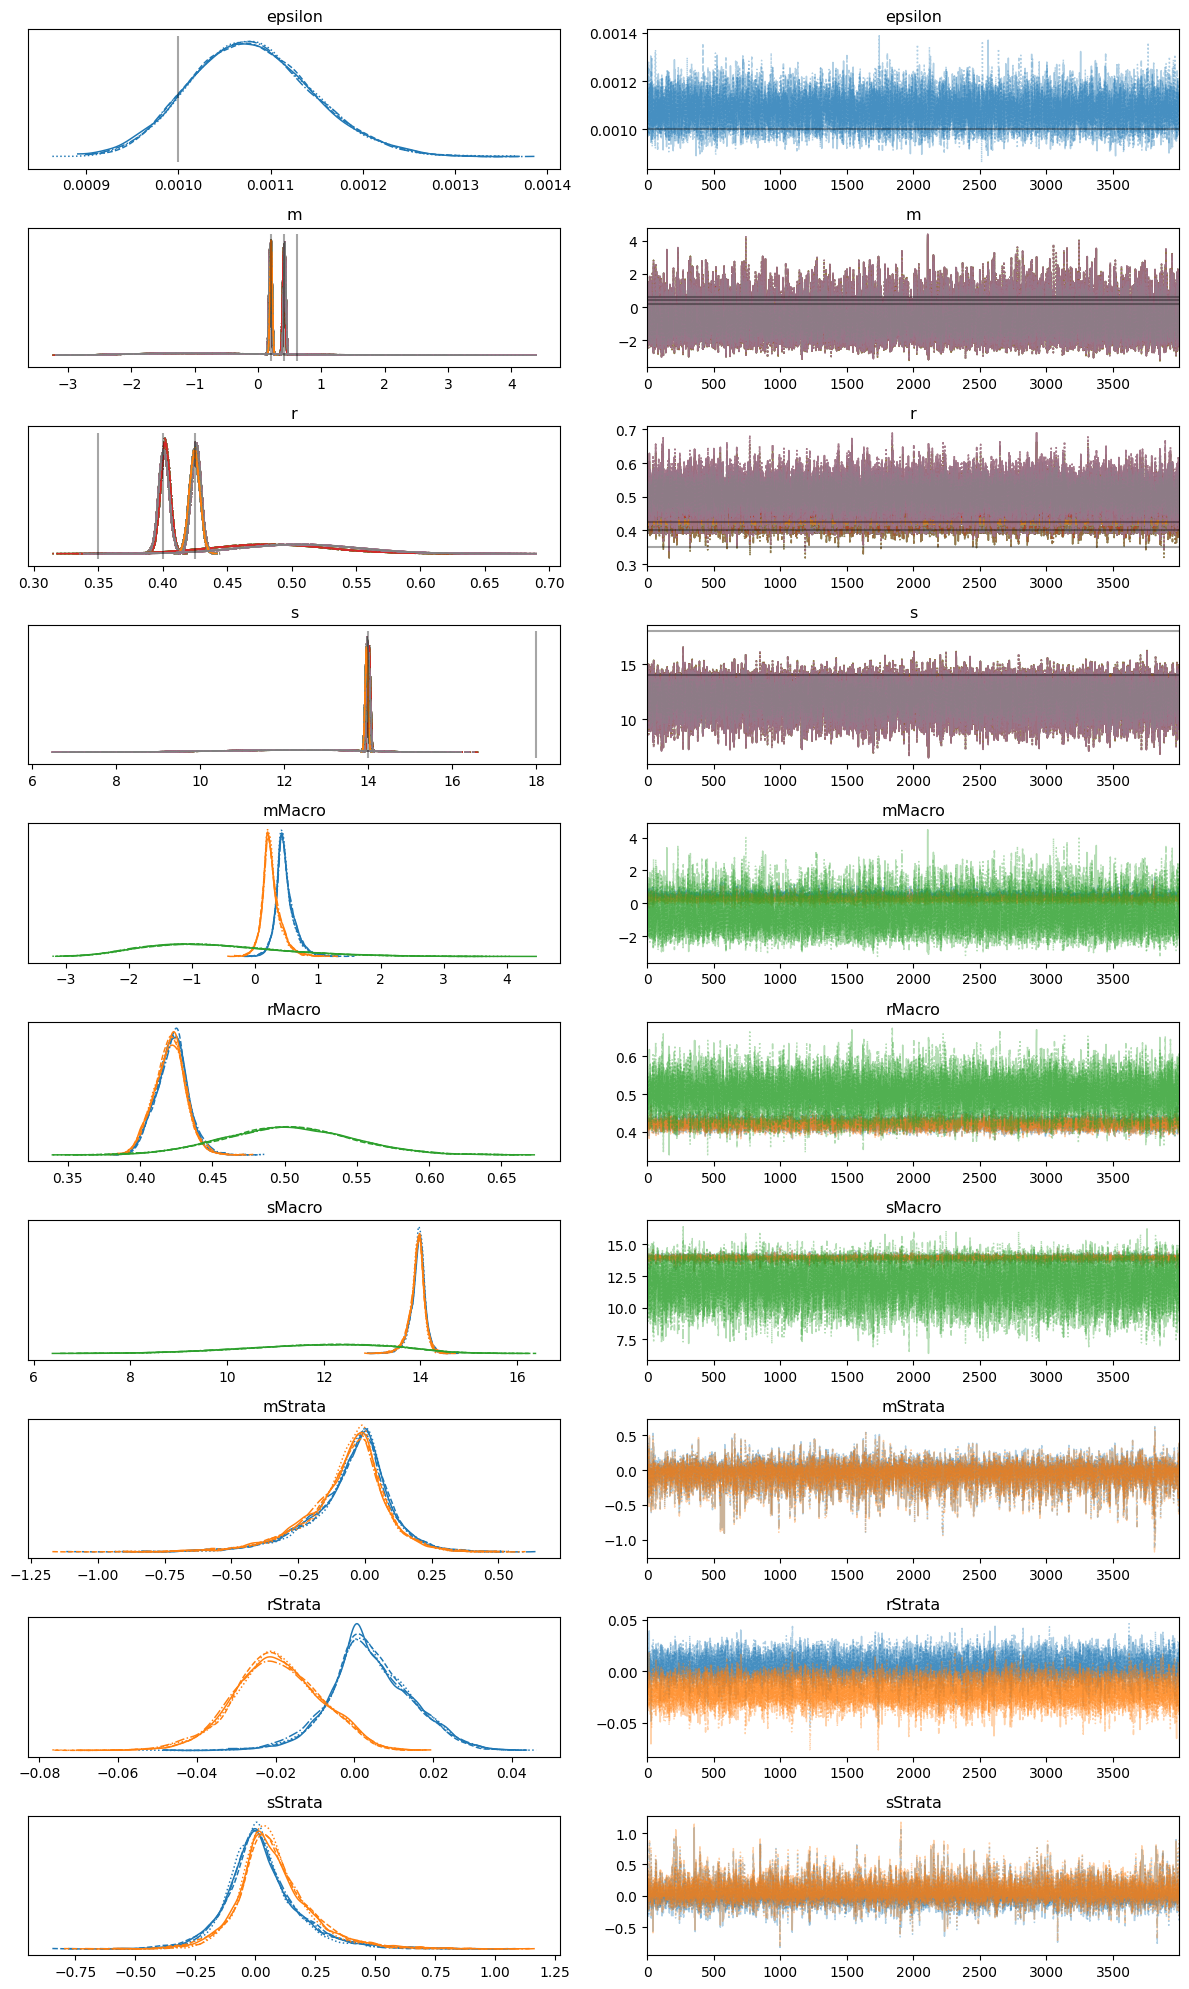

In [25]:
axes = az.plot_trace(
    trace_midway,
    var_names=[
        "epsilon",
        "m",
        "r",
        "s",
        "mMacro",
        "rMacro",
        "sMacro",
        "mStrata",
        "rStrata",
        "sStrata",
    ],
    kind="trace",
    lines=[
        ("epsilon", {}, 0.001),
        ("m", {}, logit([0.6, 0.55, 0.65])),
        ("r", {}, [0.4, 0.425, 0.35]),
        ("s", {}, [14.0, 18.0]),
    ],
)
plt.tight_layout()

In [26]:
results = change_detection(
    trace_before,
    trace_midway,
    (
        {
            "T-Test": lambda x, y: ttest_ind(x, y, equal_var=False),
            "Mean": lambda x, y: np.mean(x) - np.mean(y),
        },
        {"U-Test": mannwhitneyu, "Median": lambda x, y: np.median(x) - np.median(y)},
    ),
    logistic_curve.parameters,
    "strata",
)
with np.errstate(divide="ignore"):
    results["p_value"] = np.log10(results["p_value"])
results

kind param    name    test  metric  test_statistic     p_value  \
0   strata     m  Female  T-Test    Mean   -1.793326e+01  -70.834112   
1   strata     m  Female  U-Test  Median    1.154172e+08  -51.642657   
2   strata     m    Male  T-Test    Mean   -2.651114e+01 -152.469301   
3   strata     m    Male  U-Test  Median    1.069810e+08 -142.030196   
4   strata     r  Female  T-Test    Mean   -2.191706e+00   -1.546560   
5   strata     r  Female  U-Test  Median    1.272088e+08   -0.470763   
6   strata     r    Male  T-Test    Mean    2.474211e+01 -133.162676   
7   strata     r    Male  U-Test  Median    1.492774e+08 -145.511684   
8   strata     s  Female  T-Test    Mean    2.287751e+00   -1.654459   
9   strata     s  Female  U-Test  Median    1.291873e+08   -0.821841   
10  strata     s    Male  T-Test    Mean    1.160904e+01  -30.368381   
11  strata     s    Male  U-Test  Median    1.380487e+08  -33.304453   

    metric_value  
0      -0.029496  
1      -0.016030  
2      -0.043650  
3      -0.029531  
4      -0.000261  
5       0.000032  
6       0.003103  
7       0.003409  
8       0.003897  
9       0.002360  
10      0.019746  
11      0.017030